## Overview

In the previous notebook, we learnt how to use [Xarray](http://xarray.pydata.org/) to work with gridded datasets. XArray is also well suited to work with georeferenced rasters - such as satellite imagery, population grids, or elevation data.[rioxarray](https://corteva.github.io/rioxarray/stable/index.html) is an extension of xarray that makes it easy to work with geospatial rasters. You can install the `rioxarray` package from the `conda-forge` channel. 

In this section, we will take 4 individual SRTM tiles around the Mt. Everest region and merge them to a single GeoTiff using RasterIO. We will also use `matplotlib` to visualize the result with some annonations.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [2]:
if 'google.colab' in str(get_ipython()):
    !pip install --quiet rioxarray

By convention, `rioxarray` is imported as `rxr`.

> Remember to always import `rioxarray` even if you are using sub-modules such as `merge_arrays`. Importing `rioxarray` activates the `rio` accessor which is required for all operations.

In [3]:
import os
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import matplotlib.pyplot as plt

In [4]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [5]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

srtm_tiles = [
  'N27E086.hgt',
  'N27E087.hgt',
  'N28E086.hgt',
  'N28E087.hgt'
]

data_url = 'https://github.com/spatialthoughts/python-dataviz-web/raw/main/data/srtm/'

for tile in srtm_tiles:
  url = '{}/{}'.format(data_url, tile)
  download(url)

## Rioxarray Basics

The `open_rasterio()` method from `rioxarray` is able to read any data source supported by. the [`rasterio`](https://rasterio.readthedocs.io/en/latest/) library. Let's open a single SRTM tile using `rioxarray`.

In [6]:
filename = 'N28E087.hgt'
file_path = os.path.join(data_folder, filename)
rds = rxr.open_rasterio(file_path)

The result is a `xarray.DataArray` object.

In [7]:
rds

<xarray.DataArray (band: 1, y: 3601, x: 3601)>
[12967201 values with dtype=int16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 87.0 87.0 87.0 87.0 87.0 ... 88.0 88.0 88.0 88.0
  * y            (y) float64 29.0 29.0 29.0 29.0 29.0 ... 28.0 28.0 28.0 28.0
    spatial_ref  int64 0
Attributes:
    _FillValue:    -32768.0
    scale_factor:  1.0
    add_offset:    0.0
    units:         m

You can access the pixel values using the `values` property which returns the array’s data as a numpy array.

In [8]:
rds.values

array([[[5217, 5211, 5208, ..., 5097, 5098, 5089],
        [5206, 5201, 5200, ..., 5080, 5075, 5069],
        [5199, 5194, 5191, ..., 5063, 5055, 5048],
        ...,
        [5347, 5345, 5343, ..., 5747, 5750, 5757],
        [5338, 5338, 5336, ..., 5737, 5740, 5747],
        [5332, 5331, 5332, ..., 5734, 5736, 5744]]], dtype=int16)

A `xarray.DataArray` object also contains 1 or more `coordinates`. Each coordinate is a 1-dimensional array representing values along one of the data axes. In case of the 1-band SRTM elevation data, we have 3 coordinates - `x`, `y` and `band`.

In [9]:
rds.coords

Coordinates:
  * band         (band) int64 1
  * x            (x) float64 87.0 87.0 87.0 87.0 87.0 ... 88.0 88.0 88.0 88.0
  * y            (y) float64 29.0 29.0 29.0 29.0 29.0 ... 28.0 28.0 28.0 28.0
    spatial_ref  int64 0

A key feature of `xarray` is the ability to access slices of the dataset using [index lookup](http://xarray.pydata.org/en/stable/user-guide/indexing.html) methods. For example, we can slice the main dataset and get the data for Band1 using the `sel()` method.

The raster metadata is stored in the [`rio`](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray-rio-accessors) accessor. This is enabled by the `rioxarray` library which provides geospatial functions on top of `xarray`. 

In [10]:
print('CRS:', rds.rio.crs)
print('Resolution:', rds.rio.resolution())
print('Bounds:', rds.rio.bounds())
print('Width:', rds.rio.width)
print('Height:', rds.rio.height)

CRS: EPSG:4326
Resolution: (0.0002777777777777778, -0.0002777777777777778)
Bounds: (86.99986111111112, 27.999861111111112, 88.00013888888888, 29.000138888888888)
Width: 3601
Height: 3601


In [11]:
band1 = rds.sel(band=1)
band1

<xarray.DataArray (y: 3601, x: 3601)>
array([[5217, 5211, 5208, ..., 5097, 5098, 5089],
       [5206, 5201, 5200, ..., 5080, 5075, 5069],
       [5199, 5194, 5191, ..., 5063, 5055, 5048],
       ...,
       [5347, 5345, 5343, ..., 5747, 5750, 5757],
       [5338, 5338, 5336, ..., 5737, 5740, 5747],
       [5332, 5331, 5332, ..., 5734, 5736, 5744]], dtype=int16)
Coordinates:
    band         int64 1
  * x            (x) float64 87.0 87.0 87.0 87.0 87.0 ... 88.0 88.0 88.0 88.0
  * y            (y) float64 29.0 29.0 29.0 29.0 29.0 ... 28.0 28.0 28.0 28.0
    spatial_ref  int64 0
Attributes:
    _FillValue:    -32768.0
    scale_factor:  1.0
    add_offset:    0.0
    units:         m

### Merging Rasters

Now that you understand the basic data structure of *xarray* and the &rio* extension, let's use it to process some data. We will take 4 individual SRTM tiles and merge them to a single GeoTiff. You will note that `rioxarray` handles the CRS and transform much better - taking care of internal details and providing a simple API.

Open each source file using `open_rasterio()` method and store the resulting datasets in a list.

In [33]:
datasets = []
for tile in srtm_tiles:
    path = os.path.join(data_folder, tile)
    rds = rxr.open_rasterio(path)
    band = rds.sel(band=1)
    datasets.append(band)

Use the `merge_arrays()` method from the `rioxarray.merge` module to merge the rasters.

In [34]:
merged = merge_arrays(datasets)
merged

<xarray.DataArray (y: 7201, x: 7201)>
array([[4916, 4926, 4931, ..., 5097, 5098, 5089],
       [4919, 4932, 4928, ..., 5080, 5075, 5069],
       [4919, 4928, 4935, ..., 5063, 5055, 5048],
       ...,
       [ 368,  368,  366, ..., 1905, 1919, 1937],
       [ 364,  364,  362, ..., 1913, 1930, 1944],
       [ 360,  359,  357, ..., 1918, 1930, 1942]], dtype=int16)
Coordinates:
  * x            (x) float64 86.0 86.0 86.0 86.0 86.0 ... 88.0 88.0 88.0 88.0
  * y            (y) float64 29.0 29.0 29.0 29.0 29.0 ... 27.0 27.0 27.0 27.0
    band         int64 1
    spatial_ref  int64 0
Attributes:
    _FillValue:    -32768
    scale_factor:  1.0
    add_offset:    0.0
    units:         m

### Visualizing Rasters using Matplotlib

`xarray` plotting functionality is built on top of the the popular `matplotlib` library. 

You cna visualize any `DataArray` object by calling `plot()` method. Here we create a row of 4 plots and render each of the source SRTM rasters. 

Instead of `xarray.plot()`, we use `xarray.plot.imshow()` which is faster for large arrays like these. 

We can use the `cmap` option to specify a color ramp. Here we are using the built-in *Greys* ramp. Appending **_r** gives us the inverted ramp with blacks representing lower elevation values.

Reference : [xarray.plot.imshow
](https://docs.xarray.dev/en/stable/generated/xarray.plot.imshow.html)

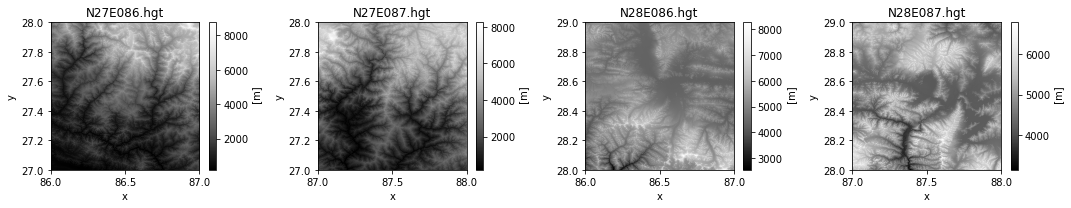

In [35]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,3)
for index, da in enumerate(datasets):
    ax = axes[index]
    im = da.plot.imshow(ax=ax, cmap='Greys_r')
    filename = srtm_tiles[index]
    ax.set_title(filename)

plt.tight_layout()
plt.show()

Similarly, we can visualize the merged raster.

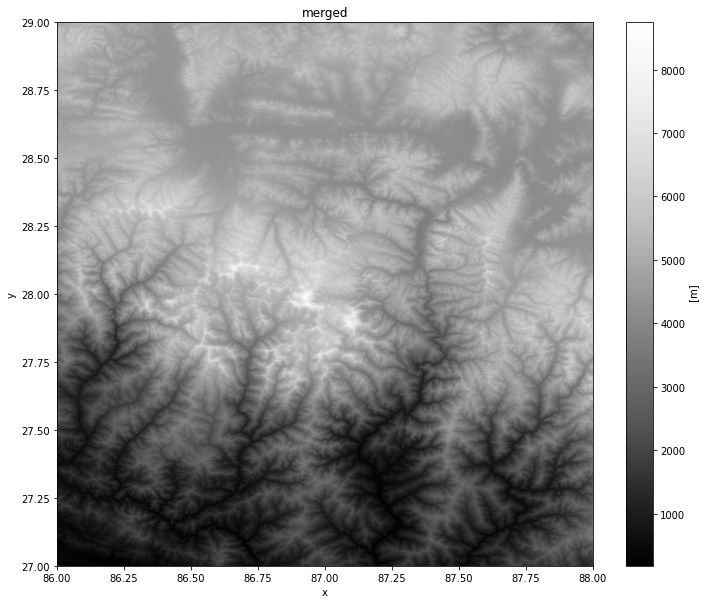

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
merged.plot.imshow(ax=ax, cmap='Greys_r')
ax.set_title('merged')
plt.show()

## Adding Annotations

In [17]:
bands, rows, cols = np.where(merged == np.max(merged))
band = bands[0]
row = rows[0]
col = cols[0]
print(band, row, col)

NameError: ignored

In [ ]:
result = merged.isel(band=band, x=col, y=row)
lat = result.y.values
lon = result.x.values
elevation = int(result)
print(lat, lon, elevation)

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 12)
merged.plot(ax=ax, cmap='viridis')
ax.plot(lon, lat, '^r', markersize=11)
ax.annotate('Mt. Everest (elevation:{}m)'.format(elevation),
            xy=(lon, lat), xycoords='data',
            xytext=(20, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='black')
            )

output_folder = 'output'
output_path = os.path.join(output_folder, 'mt_everest.png')
plt.savefig(output_path, dpi=300)

plt.show()

Finally, save the merged array to disk as a GeoTiff file.

In [ ]:
output_filename = 'merged.tif'
output_path = os.path.join(data_folder, output_filename)
merged.rio.to_raster(output_path)